In [1]:
from timeit import default_timer as timer
from datetime import timedelta

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [3]:
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cuda


In [4]:
%load_ext autoreload
%autoreload 2

import data_handling as data
import preprocess as pp
from models import nvdm

In [5]:
# # Original data
# DATA_RAW_PATH = "./data/bds_1.txt"
# IDs, BDs = data.load_raw(DATA_RAW_PATH)

In [6]:
# Data that has already been preprocessed
# Generated by applying pp.preprocess_text() to each BD,
# then saved to a TSV
DATA_CLEAN_PATH = "./data/bds_1_clean.txt"
IDs_raw, BDs_raw = data.load_raw(DATA_CLEAN_PATH)

In [7]:
# Some entries have empty BDs, so filter those out
IDs = []
BDs = []
for iid, bd in zip(IDs_raw, BDs_raw):
    if len(bd) > 0:
        IDs.append(iid)
        BDs.append(bd)

print(len(IDs), len(BDs))

2034 2034


Following PyTorch's tutorial for data setup.
https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html

In [8]:
# Build frequency table
# (cleaned data joins tokens by space)
counter = Counter()
for desc in BDs:
    counter.update(desc.split(" "))

In [9]:
# PyTorch torchtext vocabulary converts tokens to indices and vice versa.
# Also has an '<unk>' for OOV words (might be useful later).
vocab = Vocab(counter,
              max_size=10000,
              min_freq=1,
              specials=['<unk>'])
print(len(vocab))
# actual is 70770 without max_size restriction

10001


In [10]:
class BDDataset(Dataset):
    """ Very simple dataset object. Stores all the passages.
    
    This is just for compatibility with PyTorch DataLoader.
    """
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [11]:
# "Preprocessing" function: just splits the text
# The file's text is already preprocessed.
def text_pipeline(text):
    return [vocab[token] for token in text.split(" ")]

def collate_batch(batch):
    """ Convert a batch of text (each a list of tokens) into appropriate torch tensors.
    
    Modification of https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html.
    We don't need labels.
    """
    # Offsets tells the model (which will use EmbeddingBag) where each text starts.
    text_list, offsets = [], [0]
    for _text in batch:
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))

    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return text_list.to(device), offsets.to(device)

In [12]:
# Create data loader to iterate over dataset in batches during training/evaluation
dataset = BDDataset(BDs)
batch_size = 64
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
hidden_size = 500
num_topics = 10

In [ ]:
# Training setup

# Total number of epochs
outer_epochs = 200

# Epochs for training the encoder/decoder on each alternation.
inner_epochs = 1

model = nvdm.NVDM(len(vocab), hidden_size, num_topics, 1, device)
model = model.to(device)
model.train()

# Separate the encoder from decoder parameters when training in an alternating manner.
# Also including linear layers than output mu and log(sigma)
# (not the most elegant method but works)
optim_encoder = torch.optim.Adam(
    list(model.encoder.parameters()) +
    list(model.mu.parameters()) +
    list(model.log_sigma.parameters()),
    lr=0.0001)
optim_decoder = torch.optim.Adam(model.decoder.parameters(), lr=0.001)

# Trains both the encoder and decoder at the same time.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

start_time = timer()

for epoch in range(outer_epochs):

    # 1. Train the encoder and decoder in turns,
    #    fixing the parameters of the other every time.
#     for switch in range(0, 2):
#         # Author's code trains the decoder first,
#         # not sure if the order matters.
#         if switch == 0:
#             optimizer = optim_encoder
#         else:
#             optimizer = optim_decoder
    
    # 2. Train everything together
    if True:
        # Do training
        for alt_epoch in range(inner_epochs):
            
            loss_sum = 0.0
            rec_sum = 0.0
            kl_sum = 0.0
            n = len(data_loader)
            
            for idx, (text, offsets) in enumerate(data_loader):
                text = text.to(device)
                offsets = offsets.to(device)
                
                optimizer.zero_grad()
                logits, loss_dict = model(text, offsets, kl_weight=1.0)
                loss = loss_dict["total"]
                loss.backward()
                
                optimizer.step()
                
                # For printing
                loss_sum += loss.item()
                rec_sum += loss_dict["rec"].item()
                kl_sum += loss_dict["kl"].item()

            model_str = "All" # "Enc" if switch == 0 else "Dec"
            print(f"[Time: {timedelta(seconds=timer() - start_time)}, Epoch {epoch + 1}, {model_str} {alt_epoch + 1}] Loss {loss_sum/n}, Rec {rec_sum/n}, KL {kl_sum/n}")

Some observations:

- The original paper alternates between the encoder and decoder when training. i.e. It trains the decoder first for some (e.g. 10) iterations, fixing the encoders parameters. Then it trains the encoder, fixing the decoder's parameters. This is one epoch, which is repeated some number of times until convergence. However, this results in poor training performance: the KL is observed to fluctuate. The encoder and decoder are unable to jointly converge. By training them all together both the reconstruction loss and KL appear to go down.
- Right now we weight the reconstruction and KL losses equally: $L_{total} = L_{rec} + L_{KL}$. We could define a hyperparameter $\beta$ so that $L_{total} = L_{rec} + \beta L_{KL}$, which might help balance the two.

In [35]:
MODELSAVE_PATH = "./modelsaves/nvdm_200epochs.pt"
# torch.save(model.state_dict(), MODELSAVE_PATH)

model = nvdm.NVDM(len(vocab), hidden_size, num_topics, 1, device)
model.load_state_dict(torch.load(MODELSAVE_PATH))
model.eval()

NVDM(
  (embed_bow): EmbeddingBag(10001, 10001, mode=sum)
  (encoder): Sequential(
    (0): Linear(in_features=10001, out_features=500, bias=True)
    (1): Tanh()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): Tanh()
  )
  (mu): Linear(in_features=500, out_features=10, bias=True)
  (log_sigma): Linear(in_features=500, out_features=10, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=10001, bias=True)
  )
)

In [36]:
# Extract the vocab-topic matrix (known as R in the paper).
# It has dimensions |V| x K: vocab size x number of topics
decoder = model.decoder[0]
weights = decoder.weight.data.detach().clone()
weights.size()

torch.Size([10001, 10])

In [37]:
# Look at some words
# manual KNN
from nltk.stem import PorterStemmer
PORTER_STEMMER = PorterStemmer()

# Set of words used in the original paper
candidates = ["weapons", "medical", "companies", "define", "israel", "book"]

for candidate in candidates:
    test_word = PORTER_STEMMER.stem(candidate)
    idx = vocab.stoi[test_word]
    print(test_word, idx)

    # Show top 10 most similar (based on cosine distance)
    sims = F.cosine_similarity(weights[idx].unsqueeze(0), weights)
    sim_vals, sim_idxs = torch.topk(sims, 15)

    # Show ith nearest word and its score.
    for i, v in zip(sim_idxs, sim_vals):
        print(f"{vocab.itos[i]}\t{v.item()}")
    
    print("-----------")

weapon 6165
weapon	1.0
command	0.9859694838523865
alarm	0.9724387526512146
catv	0.9687132239341736
nondisclosur	0.9681808948516846
harsh	0.9667993783950806
microwav	0.9648943543434143
dana	0.961925208568573
surg	0.959961473941803
newest	0.9583815932273865
warfar	0.9568072557449341
lightweight	0.9552127718925476
humid	0.9520108699798584
lockhe	0.9518946409225464
electromagnet	0.9515492916107178
-----------
medic 235
medic	1.0
health	0.9257354736328125
healthcar	0.9163874983787537
care	0.8989317417144775
afford	0.8853657841682434
bodi	0.870684027671814
hospit	0.851254403591156
patient	0.8428614735603333
often	0.8355170488357544
both	0.8289807438850403
treatment	0.8267985582351685
physician	0.8263426423072815
supplement	0.8239941596984863
fine	0.8207406997680664
age	0.8182672262191772
-----------
compani 3
compani	1.0
corpor	0.9685456156730652
As	0.9668803811073303
offic	0.9664745330810547
maintain	0.9538002610206604
sourc	0.9514853358268738
factor	0.9485275745391846
meet	0.94704395532608

In [41]:
# Look at most similar words per topic vector.

V, K = weights.size()
for i in range(K):
    print(f"Topic {i+1}")
    vals, idxs = torch.topk(torch.abs(weights[:, i]), 30)
    for i, v in zip(idxs, vals):
        print(f"{vocab.itos[i]}\t{v.item()}")
    print("------------")

Topic 1
iiot	1.5719436407089233
mifid	1.5622806549072266
sef	1.552869439125061
sdk	1.5519018173217773
ria	1.4965932369232178
modem	1.4920049905776978
guidewir	1.4848800897598267
interbodi	1.4842369556427002
cgm	1.4779086112976074
ghz	1.474395990371704
dexcom	1.469714879989624
plane	1.4693533182144165
clia	1.4622814655303955
interoper	1.4570252895355225
mbp	1.453446626663208
iot	1.4483671188354492
peek	1.4462167024612427
voip	1.4388659000396729
exoskeleton	1.4301104545593262
m2m	1.423481822013855
cpt	1.4216123819351196
cellfx	1.420039415359497
mridium	1.4180893898010254
bluetooth	1.4171274900436401
excim	1.412894368171692
saa	1.408990502357483
ott	1.4067158699035645
router	1.4054046869277954
oracl	1.400571346282959
labview	1.3922574520111084
------------
Topic 2
biotherapeut	2.1294736862182617
cd20	2.0815372467041016
dendrit	2.0779407024383545
lymphoblast	2.07721209526062
linker	2.0732641220092773
antigen	2.061290979385376
cellecti	2.0539138317108154
cd19	2.0537850856781006
microenviron

# Part 2 Full Evaluation

In [28]:
def analysis(model):
    """ Qualitative analysis of topic model. """
    
    PORTER_STEMMER = PorterStemmer()
    # Set of words used in the original NVDM paper
    candidates = ["weapons", "medical", "companies", "define", "israel", "book"]
    
    # Extract the vocab-topic matrix (known as R in the paper).
    # It has dimensions |V| x K: vocab size x number of topics
    decoder = model.decoder[0]
    weights = decoder.weight.data.detach().clone()

    for candidate in candidates:
        test_word = PORTER_STEMMER.stem(candidate)
        idx = vocab.stoi[test_word]
        print(test_word, idx)

        # Show top 10 most similar (based on cosine distance)
        sims = F.cosine_similarity(weights[idx].unsqueeze(0), weights)
        sim_vals, sim_idxs = torch.topk(sims, 15)

        # Show ith nearest word and its score.
        for i, v in zip(sim_idxs, sim_vals):
            print(f"{vocab.itos[i]}\t{v.item()}")

        print("-----------")
    
    V, K = weights.size()
    for i in range(K):
        print(f"Topic {i+1}")
        vals, idxs = torch.topk(torch.abs(weights[:, i]), 30)
        for i, v in zip(idxs, vals):
            print(f"{vocab.itos[i]}\t{v.item()}")
        print("------------")

In [38]:
# Topic coherence.
def umass_score(tf):
    """ Compute topic coherence using UMass metric.
    
    Ref: http://qpleple.com/topic-coherence-to-evaluate-topic-models/
    
    tf: term-frequency matrix for each document.
        Each i^th row is the BOW representation of the i^th document.
    """
    
    # D(wi): count of documents containing the word wi (i.e. df)
    Dwi = np.array(np.sum(tf > 0, axis=0))[0]

    W_bin = np.zeros_like(tf)
    W_bin[tf > 0] = 1
    
    # D(wi, wj): count of documents containing both words wi and wj
    Dwi_wj = W_bin.T @ W_bin

    score_umass = np.log((Dwi_wj + 1)/ Dwi)
    
    return score_umass


def topic_coherence(topic_vocab, n_top_words, pair_score):
    """
    topic_vocab: dimensions (number of topics, vocabulary size).
    model.components_ for LDA, and the "semantic embedding" matrix in the decoder for NVDM.
    
    pair_score: matrix of scores (e.g. UMass)
    """
    coherences = []
    for topic_idx, topic in enumerate(topic_vocab):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        coh = 0
        for i in range(len(top_features_ind)):
            for j in range(i):
                coh += pair_score[top_features_ind[i], top_features_ind[j]]
        coherences.append(coh)
    return coherences

In [42]:
import os
import re

from nltk.stem import PorterStemmer


MODELSAVE_PATH = "./modelsaves"

models_k = dict()
k_values = []

for filename in os.listdir(MODELSAVE_PATH):
    
    num_topics = filename.split("_")[1][1:]
    num_topics = int(num_topics)
    k_values.append(num_topics)
    
    model = nvdm.NVDM(len(vocab), hidden_size, num_topics, 1, "cpu")
    model.load_state_dict(torch.load(os.path.join(MODELSAVE_PATH, filename), map_location="cpu"))
    model.eval()
    models_k[num_topics] = model


In [43]:
# Make the BOW matrix manually, using the existing Vocab's token-to-index mapping.
bow_mat = np.zeros((len(BDs), len(vocab)))
for d, bd in enumerate(BDs):
    token_idxs = vocab.lookup_indices(bd.split(" "))
    word_counts = Counter(token_idxs)
    for w, count in word_counts.items():
        bow_mat[d, w] = count   
bow_mat.shape

(2034, 10001)

In [44]:
score_umass_mat = umass_score(bow_mat)

In [88]:
k_values.sort()
tc_values = []

for k in k_values:
    print(f'Running k = {k}')
    this_model = models_k[k]
    
    # Extract the topic vocab matrix
    decoder = this_model.decoder[0]
    weights = decoder.weight.data.detach().clone().numpy()
    topic_vocab_mat = weights.T
    coherences = topic_coherence(topic_vocab_mat, 10, score_umass_mat)
    this_c = np.median(coherences)

    tc_values.append(this_c)

Running k = 5
Running k = 10
Running k = 15
Running k = 20
Running k = 25
Running k = 30
Running k = 35
Running k = 40
Running k = 50


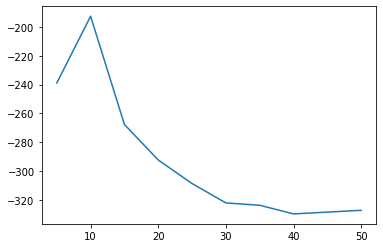

In [89]:
plt.plot(k_values, tc_values);

In [90]:
def plot_top_words(topic_vocab, feature_names, n_top_words, title):
    K = len(topic_vocab)
    n_x = 5
    n_y = int(np.ceil(K / n_x))
    fig, axes = plt.subplots(n_y, n_x, figsize=(2.5 * n_x, 4 * n_y), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(topic_vocab):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 14})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=12)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=20)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [91]:
feature_names = [vocab.itos[i] for i in range(0, len(vocab))]

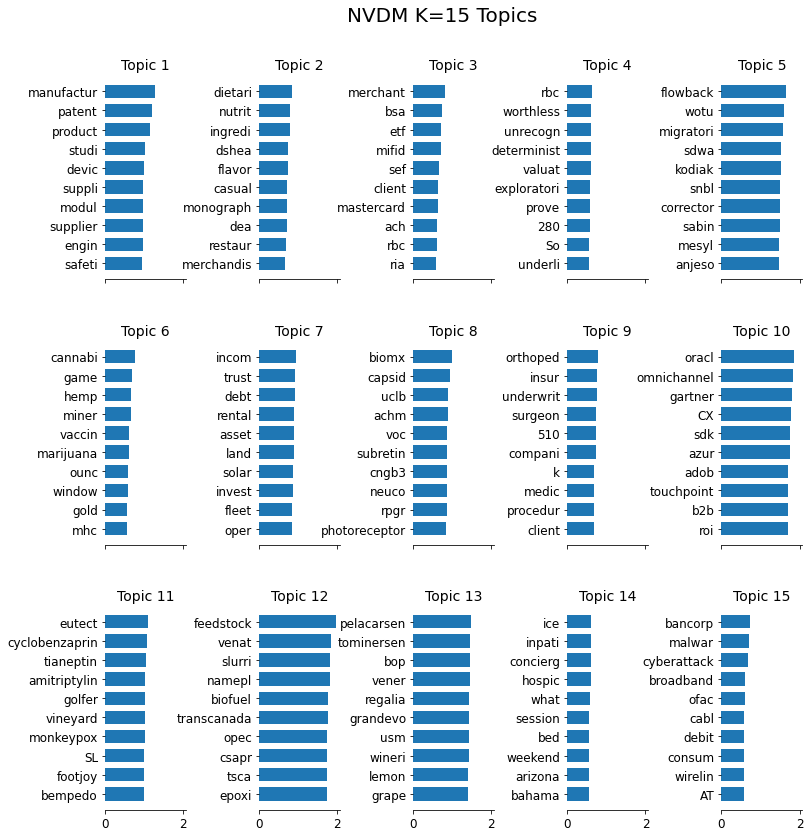

In [95]:
k = 15
this_model = models_k[k]
decoder = this_model.decoder[0]
weights = decoder.weight.data.detach().clone().numpy()
topic_vocab_mat = weights.T

plot_top_words(topic_vocab_mat, feature_names, 10, f"NVDM K={k} Topics")